# Exercise 04: Molecular dynamics

The expected velocity distribution in for particles in a gaseous state is the Maxwell-Boltzmann:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$ 
In this exercise, I modified the NSL_SIMULATOR code by adding methods to measure the velocity distribution of the system and to analyze its evolution under different initial conditions.

First, I studied the dynamics starting from an initial Maxwell-Boltzmann distribution. This served as a useful validation of the measurement strategy, particularly the data blocking technique.

Next, I initialized the system with a Dirac delta velocity distribution and observed how its thermodynamic properties—most notably the increase in entropy—drove the evolution toward the Maxwell-Boltzmann equilibrium.

Finally, I attempted to reverse this process by inverting the direction of time, in order to see whether it would be possible to effectively decrease the entropy and recover the initial Dirac delta distribution.

## 04.1
**Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.**



The initial state of the system is specified in the input file: I am using a very low particle density and high temperature to reproduce a gas state:
```
SIMULATION_TYPE        0
RESTART                0
TEMP                   2.0
NPART                  108
RHO                    0.05
R_CUT                  5.0
DELTA                  0.001
NBLOCKS                30
NSTEPS                 2000

ENDINPUT

To measure the velocity distribution, the program constructs a histogram that, at each simulation step, increments the bin corresponding to the measured particle velocity. The number of bins is specified in the input configuration file; in this case, I am using 30 velocity bins.

The bin size must be chosen carefully: the total velocity range should be significantly broader than the width of the Maxwell-Boltzmann distribution to ensure that the tails are captured without losing meaningful data. At the same time, the range should not be so large that it burdens the computation with many empty bins.
A convenient value for the bin size is:
```c++
_bin_size_v = 4.0*sqrt(_temp)/(double)_n_bins_v


In fact, with $T=2$:
$$\int_0 ^{4\sqrt{T}} P(v,T^*) = 0.999$$

Since the simulation starts from a crystalline FCC configuration in which all particles are at rest, an initial equilibration phase is expected, during which the actual temperature deviates from the target value. To monitor this, I recorded the instantaneous temperature at the beginning and estimated how many steps were required for the system to reach the desired temperature. From this analysis, I determined that starting from T=1.8 and performing 2500 steps is sufficient to reach equilibrium.

Below is the code used for the equilibration phase, together with the temperature evolution plot. From this figure, it is evident that after this process the temperature stabilizes, confirming that the system is sufficiently equilibrated to begin the measurement phase.

```c++
    //EQUILIBRATION:////////////////////////////////////////////////////////////////////
    /* 
    cout<<YELLOW<<"Equilibration started at temperature "<<SYS.Get_Temp()<<endl;
    
    ofstream out("../OUTPUT/Equilibration.csv");
    out<<"Step\tTemp"<<endl;
    for (int i=0;i<2500;i++){
        SYS.step();
        SYS.measure();
        out<<i<<"\t"<<SYS.Get_Temp()<<endl;
    }
    out.close();
    cout<<"Equilibration completed at temperature T="<<SYS.Get_Temp()<<RESET<<endl;

    SYS.Reset_Averages();
    SYS.block_reset(0); //resets block accumulators to zero

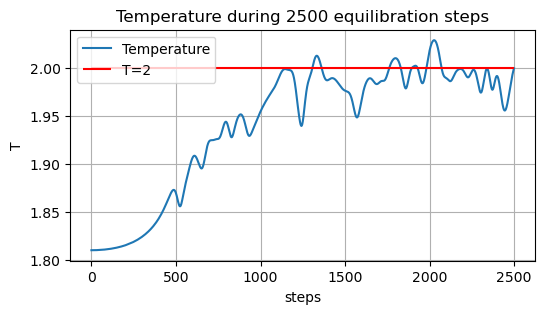

In [8]:
import pandas as pd
file= "./OUTPUT/Equilibration.csv"
df1 = pd.read_csv(file,sep ="\t")

import matplotlib.pyplot as plt
fig =plt.figure(figsize=(6,3))
Neq_steps=len(df1['Step'])

plt.plot(df1['Step'],df1['Temp'],label = 'Temperature')
plt.hlines(2.0,0,Neq_steps,color='r',label = 'T=2')
plt.xlabel('steps')
plt.ylabel('T')
plt.legend()
plt.title(f'Temperature during {Neq_steps} equilibration steps')
plt.grid()
plt.show()

In [9]:
T=df1['Temp'][2499]
print(f'Equilibrium temperature: T={T}')

Equilibrium temperature: T=1.99951


To perform the Maxwell-Boltzmann distribution measurement I modified the *measure()* function of the *system* class with a method that, spanning over all particles, measures the norm of their velocity and checks in which velocity bin of the histogram it falls in.

```c++
if (_measure_pofv){
vec velocities(_npart);
velocities.zeros();
for (int i=0; i<_npart;i++){   
  velocities (i) = sqrt(dot( _particle(i).getvelocity() , _particle(i).getvelocity() ));
  for (int j=0;j<_n_bins_v;j++){
    double v_inf=(j+1)*_bin_size_v;
    double v_sup = v_inf + _bin_size_v;
    if (velocities(i)>v_inf && velocities(i)<=v_sup) _measurement(_index_pofv+j) ++;
       
  }     
  }
} 

The output of the simulation is the file pofv.csv, which contains the histogram bin contents for each block, separated by blank lines. This data allows me to study how the velocity distribution evolves over time and to verify that it approaches the expected Maxwell-Boltzmann distribution.

In [10]:
#READING DATA FILE
#first two lines of the file contain information about the bin size and initial distrinution (Maxwell-Boltzmann in this case)
file= "./OUTPUT/pofv.csv"
import pandas as pd

header = pd.read_csv(file, sep="\t", nrows=2, header=None)
distrib_type = header.iloc[0,1]
bin_size = float(header.iloc[1,1])
print(header.values)

df = pd.read_csv(file,sep ="\t", skiprows=2, skip_blank_lines = False)

[['INITIAL DISTRIBUTION' 'MB']
 ['BIN SIZE' '0.179382']]


In [11]:
def Maxwell_Boltzmann (v,T) : #theoretical Maxwell-Boltzmann distribution
    return 1/np.pow((2* np.pi*T),3/2)*4*np.pi*v*v*np.exp(-v*v/(2*T))

In [12]:
#function for generic histogram plot
def plot_hist(ax_row, i,histograms,h_idx,with_error=False):
    h=histograms[h_idx]
    y = h['AVE'] / area
    yprog = h['PROG_AVE_POFV'] / area
    err = h['ERROR'] / area

    ax_row[i].bar(bin_centers, yprog if with_error else y,
                  yerr=err if with_error else None,
                  width=bin_size, color=colors[h_idx], edgecolor='black',
                  linewidth=1.5, alpha=0.5, label=f'Block {h_idx + 1}', capsize=2)
    

    title = 'Progressive average' if with_error else 'Normalized average'
    ax_row[i].set_title(f'{title} at block {h_idx + 1}')
    ax_row[i].set_xlabel('Velocity')
    ax_row[i].set_ylabel('P(v)')
    ax_row[i].legend()

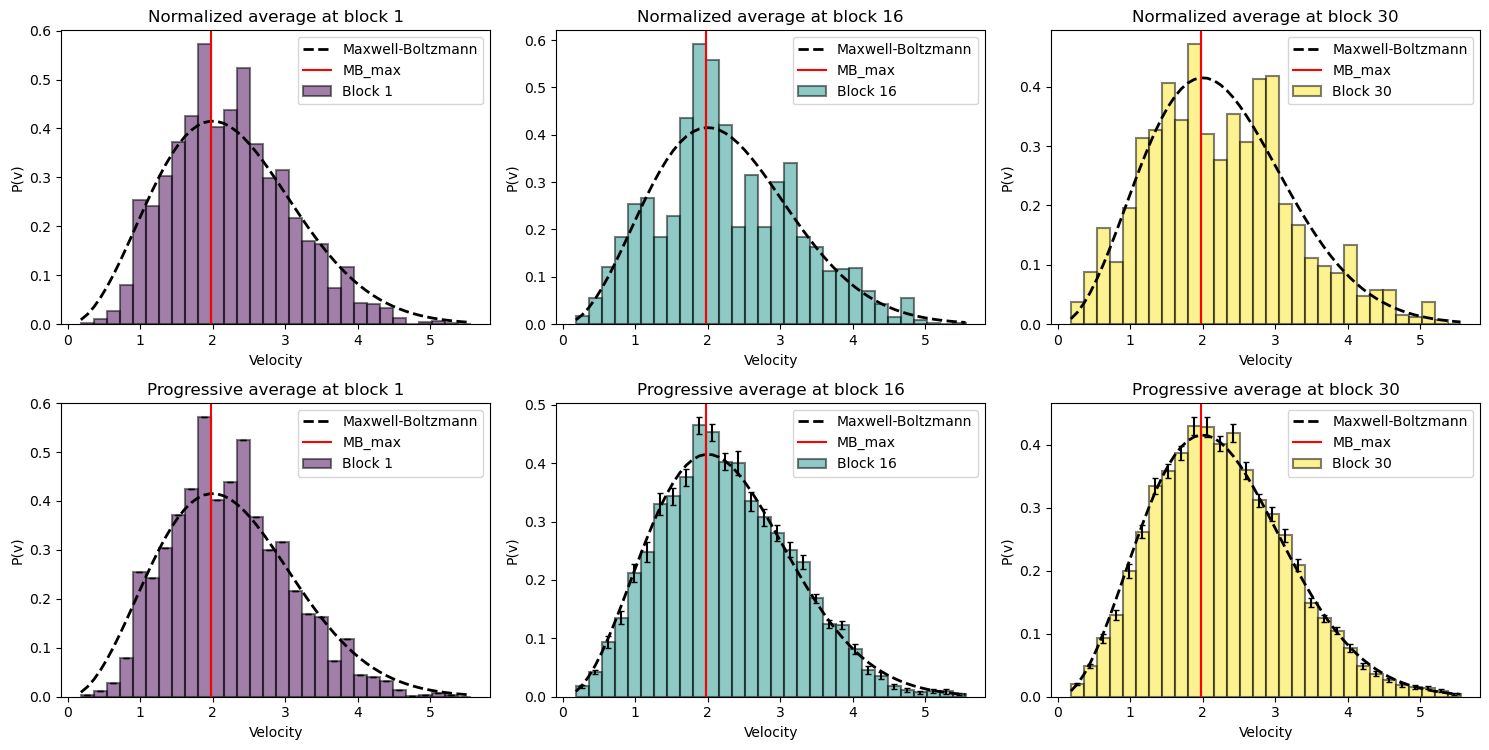

In [14]:
#define histograms from file
split_points = [-1] + df[df.isnull().all(axis=1)].index.tolist() + [len(df)]#finds blank rows'indices
histograms = [df.iloc[split_points[i]+1:split_points[i+1]].reset_index(drop=True) #define individual block histograms
              for i in range(len(split_points) - 1) if not df.iloc[split_points[i]+1:split_points[i+1]].empty]
#plot histogrmas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

to_plot = [0,15,29]

n_cols = len(to_plot)
fig, ax = plt.subplots(2, n_cols, figsize=(5 * n_cols, 8), sharex=False, sharey=False)

colors = plt.cm.viridis(np.linspace(0, 1, 30))
h = histograms[0]
bin_centers = h['VMIN']+0.5*(h['VMAX']-h['VMIN'])
v_all = np.concatenate((h['VMIN'].values, bin_centers, h['VMAX'].values))
v_all = np.unique(v_all)  # Remove duplicates and sort

# Maxwell-Boltzmann distribution
mb_curve = Maxwell_Boltzmann(v_all, T)
vmax = v_all[np.argmax(mb_curve)]

area = bin_size*108.

for axes in ax.flat:
    axes.plot(v_all, mb_curve, 'k--', linewidth=2, label='Maxwell-Boltzmann')
    axes.axvline(vmax, color='red', linewidth=1.5, label=f'MB_max')
for i, h_idx in enumerate(to_plot):
    plot_hist(ax[0], i, histograms,h_idx,with_error=False)
    plot_hist(ax[1], i, histograms,h_idx, with_error=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 04.2
**Perform MD simulations via a Lennard-Jones model in the following conditions:**
- **gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)**

**starting from a very low entropic initial configuration:**
1. **initial particle positions: fcc crystal occupying half of the simulation box in each dimension**
2. **initial velocity distribution:** $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$ 

**The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.**

To define a Dirac delta distribution, I modified the *initialize_velocities()* method, that is called at the end of the initialization, setting each particle velocity to a fixed value $v_T$ around one randomly chosen coordinate ax. 
The temperature of a 3D system is connected to the kinetic energy by $E_k=\frac{1}{2}|v|^2=\frac{3}{2}k_B T$, and in natural units $k_B=1$, so the optimal choice for the initial velocities is $v_T = \sqrt{3T^*}$

```c++
    if (_vdistr==1){ //initial velocity distributionis chosen as input: 0 is Maxwell-Boltzmann, 1 is Dirac delta
      double vT= sqrt(3*_temp); //center of the distribution
      
      for (int i=0; i<_npart; i++){
        double r1 = _rnd.Rannyu(); //to choose sign of the velocity 
        double r2 =_rnd.Rannyu(); //to choose axis
        bool direction = true;
        
         if(r1 >=0.5) direction = false;

         if (r2<1./3. && direction == true) vx(i)=vT;
         if (r2<1./3. && direction == false) vx(i)=-vT;

         if (r2>1./3. && r2<2./3.&& direction == true) vy(i)=vT;
         if (r2>1./3. && r2<2./3. &&direction == false) vy(i)=-vT;

        if (r2>2./3. && direction == true) vz(i)=vT;
         if (r2>2./3. && direction == false) vz(i)=-vT;

         }


The measurement procedure remains the same as before, with the difference that equilibration is no longer necessary: the goal is precisely to observe how the system evolves toward equilibrium from this non-equilibrated state. Additionally, to better capture the approach to the Maxwell-Boltzmann distribution, I used a larger number of blocks (n_bl = 50,000) with a smaller number of steps per block (n_steps = 20). These are the input parameters the simulation starts from.

```
SIMULATION_TYPE        0
RESTART                0
TEMP                   2.0
NPART                  108
RHO                    0.05
R_CUT                  5.0
DELTA                  0.001
NBLOCKS                5000
NSTEPS                 20
VDISTR                 1 //added an input to choose initial velocity distribution(0 for MB,1 for delta)

ENDINPUT


In [16]:
#READING DATA FILE
#first two lines of the file contain information about the bin size and initial distrinution (Maxwell-Boltzmann in this case)
file= "./OUTPUT/pofv.csv"
import pandas as pd

header = pd.read_csv(file, sep="\t", nrows=2, header=None)
distrib_type = header.iloc[0,1]
bin_size = float(header.iloc[1,1])
print(header.values)

df = pd.read_csv(file,sep ="\t", skiprows=2, skip_blank_lines = False)

[['INITIAL DISTRIBUTION' 'DELTA']
 ['BIN SIZE' '0.179382']]


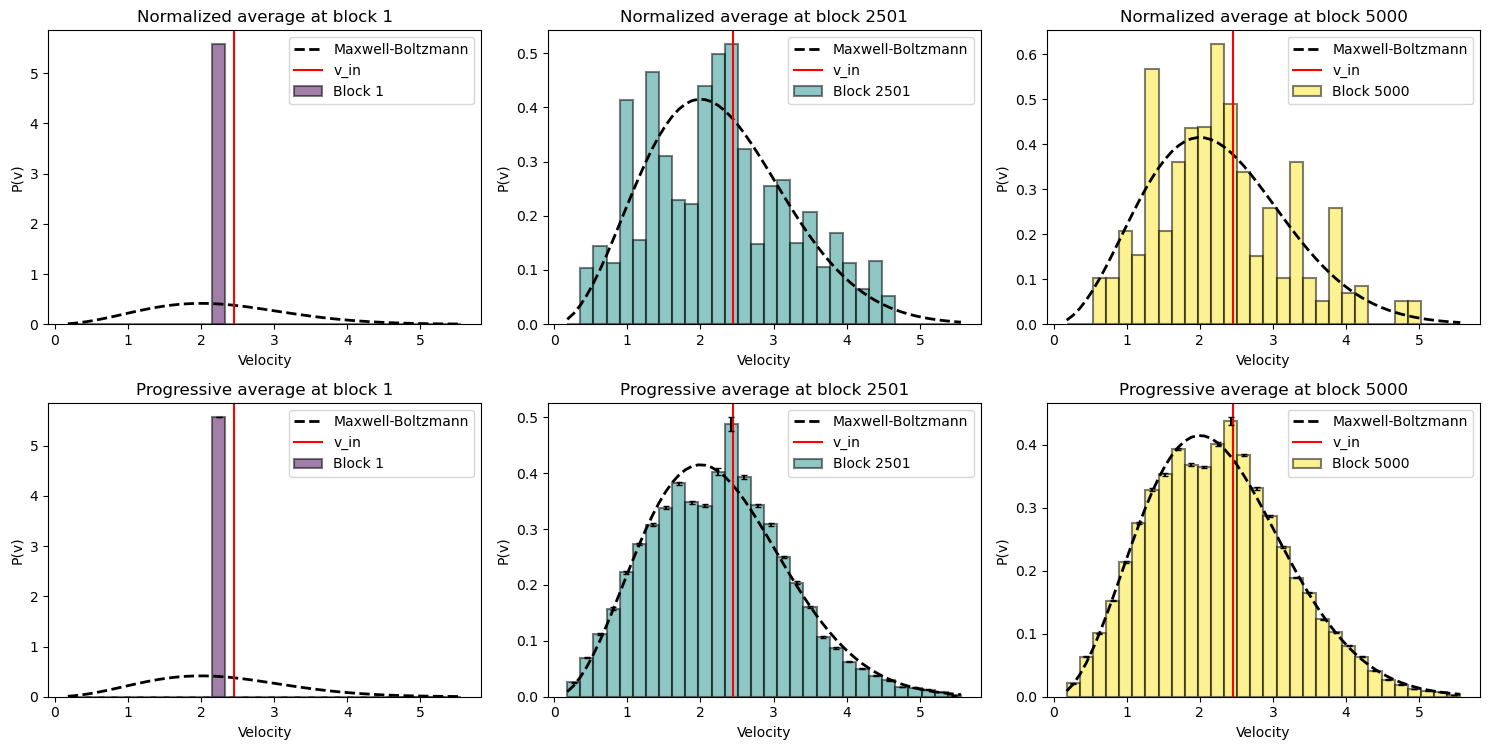

In [18]:
#define histograms from file
split_points = [-1] + df[df.isnull().all(axis=1)].index.tolist() + [len(df)]#finds blank rows'indices
histograms = [df.iloc[split_points[i]+1:split_points[i+1]].reset_index(drop=True) #define individual block histograms
              for i in range(len(split_points) - 1) if not df.iloc[split_points[i]+1:split_points[i+1]].empty]
#plot histogrmas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

to_plot = [0,2500,4999]

n_cols = len(to_plot)
fig, ax = plt.subplots(2, n_cols, figsize=(5 * n_cols, 8), sharex=False, sharey=False)

colors = plt.cm.viridis(np.linspace(0, 1, 5000))
T=2
h = histograms[0]
bin_centers = h['VMIN']+0.5*(h['VMAX']-h['VMIN'])
v_all = np.concatenate((h['VMIN'].values, bin_centers, h['VMAX'].values))
v_all = np.unique(v_all)  # Remove duplicates and sort

vstart=np.sqrt(3*T)

# Maxwell-Boltzmann distribution
mb_curve = Maxwell_Boltzmann(v_all, T)
vmax = v_all[np.argmax(mb_curve)]

area = bin_size*108.

for axes in ax.flat:
    axes.plot(v_all, mb_curve, 'k--', linewidth=2, label='Maxwell-Boltzmann')
    axes.axvline(vstart, color='red', linewidth=1.5, label=f'v_in')
for i, h_idx in enumerate(to_plot):
    plot_hist(ax[0], i,histograms,h_idx)
    plot_hist(ax[1], i, histograms,h_idx, with_error=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 04.3
**What would you find when changing the direction  of time?**

To study time reversal starting from an equilibrated configuration, I first let the system evolve normally for 10,000 steps. Then, I added an input property to the input.dat file that allows the user to select the time direction in which the simulation proceeds. This property is linked to a boolean variable *_time_inv*, which I initially set to 0 to let the system equilibrate.

I implemented a new function, *time_inv()*, which sets _time_inv to 1 to enable time reversal and swaps the current particle positions with the stored ones.

```c++
void System::time_inv() {
  _time_inversion=1;
  double x,y,z;
  for(int i =0;i<_npart;i++){
    x= _particle(i).getposition(0,true);
    y = _particle(i).getposition(1,true);
    z= _particle(i).getposition(2,true);

    //r(t)-> r(t-dt)
     _particle(i).setposition(0,_particle(i).getposition(0,false));
     _particle(i).setposition(1,_particle(i).getposition(1,false));
     _particle(i).setposition(2,_particle(i).getposition(2,false));

     //r(t-dt) -> r(t)
     _particle(i).setpositold(0,x);
      _particle(i).setpositold(1,y);
       _particle(i).setpositold(2,z);

  }
}

Finally, I modified the Verlet algorithm to check the _time_inv flag: if the simulation is evolving forward in time, the algorithm runs as usual; if it is evolving backward, the particle velocities are inverted.

```c++
else{ //TIME-INVERTED VERLET

  for(int i=0; i<_npart; i++){ 
    xnew = this->pbc( 2.0 * _particle(i).getposition(0,true) - _particle(i).getposition(0,false) + _fx(i) * pow(_delta,2), 0);
    ynew = this->pbc( 2.0 * _particle(i).getposition(1,true) - _particle(i).getposition(1,false) + _fy(i) * pow(_delta,2), 1);
    znew = this->pbc( 2.0 * _particle(i).getposition(2,true) - _particle(i).getposition(2,false) + _fz(i) * pow(_delta,2), 2);
    //velocity sign is inverted
    _particle(i).setvelocity(0,-1*( this->pbc(xnew-_particle(i).getposition(0,false), 0)/(2.0 * _delta)));
    _particle(i).setvelocity(1, -1*(this->pbc(ynew - _particle(i).getposition(1,false), 1)/(2.0 * _delta)));
    _particle(i).setvelocity(2, -1*(this->pbc(znew - _particle(i).getposition(2,false), 2)/(2.0 * _delta)));
    _particle(i).acceptmove();
    _particle(i).setposition(0, xnew);
    _particle(i).setposition(1, ynew);
    _particle(i).setposition(2, znew);
  } 

To visualize the evolution, I simulated a very large number of blocks (5000), each consisting of 10 steps. From the following plots, we can see two main results:
- The average values in each block, representing the instantaneous state of the system, are the exact mirror image of the forward evolution. This demonstrates that the time reversal is working correctly.

- The progressive average of the temperature does not change significantly, indicating that the system does not revert back to the initial Dirac delta distribution. This will be even more evident in the velocity distribution plots.

The simulation initial conditions are:

```
SIMULATION_TYPE        0
RESTART                0
TEMP                   2.0
NPART                  108
RHO                    0.05
R_CUT                  5.0
DELTA                  0.001
NBLOCKS                10000
NSTEPS                 1
VDISTR                 1
TIME_INV               0 #added an input to decide direction of evolution (0: forwards, 1:backwards)

ENDINPUT

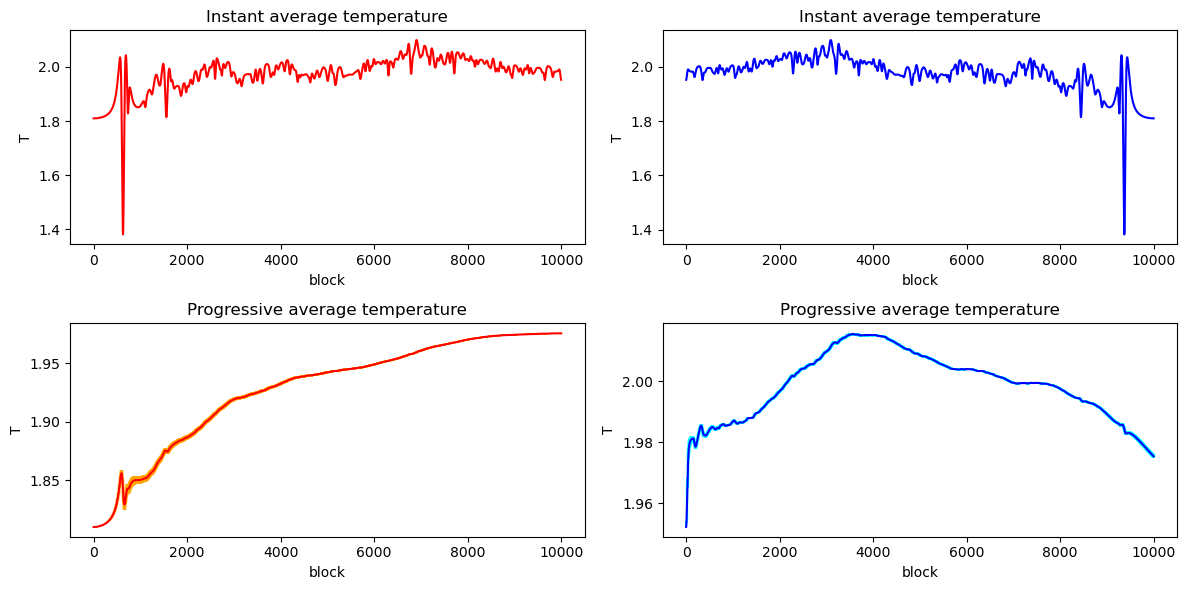

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

df_temp = pd.read_csv('./OUTPUT/temperature.csv',sep = '\t')
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

colors = {1: ('red', 'orange'), -1: ('blue', 'cyan')}
labels = {1: 'dt>0', -1: 'dt<0'}

for i,sign in enumerate([1, -1]):
    mask = df_temp['T_SIGN'] == sign
    block = df_temp.loc[mask, 'BLOCK']
    
    ax[0,i].plot(block, df_temp.loc[mask, 'ACTUAL_T'],
               c=colors[sign][0], label=labels[sign])

    ax[0,i].set_xlabel('block')
    ax[0,i].set_ylabel('T')
    ax[0,i].set_title('Instant average temperature')

    ax[1,i].errorbar(block, df_temp.loc[mask, 'T_AVE'],
                   yerr=df_temp.loc[mask, 'ERROR'],
                   c=colors[sign][0], ecolor=colors[sign][1], label=labels[sign])
    ax[1,i].set_xlabel('block')
    ax[1,i].set_ylabel('T')
    ax[1,i].set_title('Progressive average temperature')



plt.tight_layout()
plt.show()


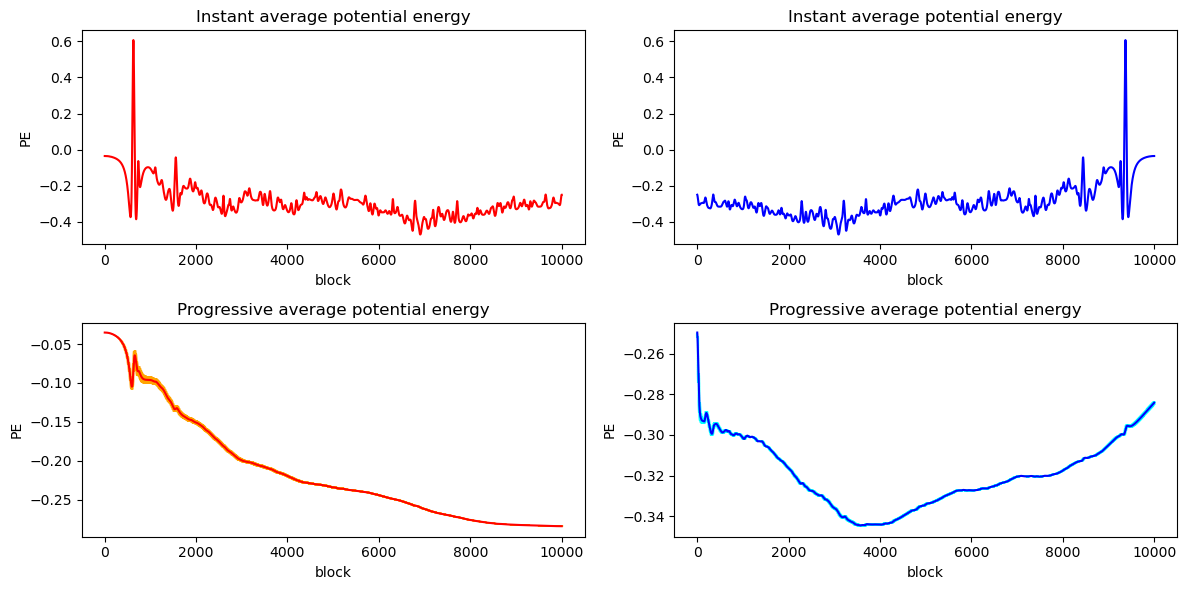

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df_u = pd.read_csv('./OUTPUT/potential_energy_MD.csv',sep = '\t')
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

colors = {1: ('red', 'orange'), -1: ('blue', 'cyan')}
labels = {1: 'dt>0', -1: 'dt<0'}

for i,sign in enumerate([1, -1]):
    mask = df_u['T_SIGN'] == sign
    block = df_u.loc[mask, 'BLOCK']
    
    ax[0,i].plot(block, df_u.loc[mask, 'ACTUAL_PE'],
               c=colors[sign][0],label=labels[sign])
    ax[0,i].set_xlabel('block')
    ax[0,i].set_ylabel('PE')
    ax[0,i].set_title('Instant average potential energy')

    ax[1,i].errorbar(block, df_u.loc[mask, 'PE_AVE'],
                   yerr=df_u.loc[mask, 'ERROR'],
                   c=colors[sign][0], ecolor=colors[sign][1], label=labels[sign])
    ax[1,i].set_xlabel('block')
    ax[1,i].set_ylabel('PE')
    ax[1,i].set_title('Progressive average potential energy')



plt.tight_layout()
plt.show()


In the pofv file, ave is the 'instantaneous' distribution in every block (so every step), while prog_ave_pofv_ keeps track of the average taking into account the previous steps(sums them and averages). The thermodinamic properties are in the sum, because verlet uses the force.

In [23]:
#READING DATA FILE
#first two lines of the file contain information about the bin size and initial distrinution (Maxwell-Boltzmann in this case)
file= "./OUTPUT/pofv.csv"
import pandas as pd

header = pd.read_csv(file, sep="\t", nrows=2, header=None)
distrib_type = header.iloc[0,1]
bin_size = float(header.iloc[1,1])
print(header.values)

df = pd.read_csv(file,sep ="\t", skiprows=2, skip_blank_lines = False)

[['INITIAL DISTRIBUTION' 'DELTA']
 ['BIN SIZE' '0.179382']]


In [24]:
# Find blank rows in the original df, not in filtered fwd_df
blank_rows = df[df.isnull().all(axis=1)].index
split_points = [-1] + list(blank_rows) + [len(df)]

fwd_histograms = []
bkw_histograms = []

for i in range(len(split_points) - 1):
    start = split_points[i] + 1
    end = split_points[i + 1]
    block = df.iloc[start:end].reset_index(drop=True)
    if not block.empty:
        tsign = block['T_SIGN'].iloc[0]
        if tsign == 1.0:
            fwd_histograms.append(block)
        elif tsign == -1.0:
            bkw_histograms.append(block)


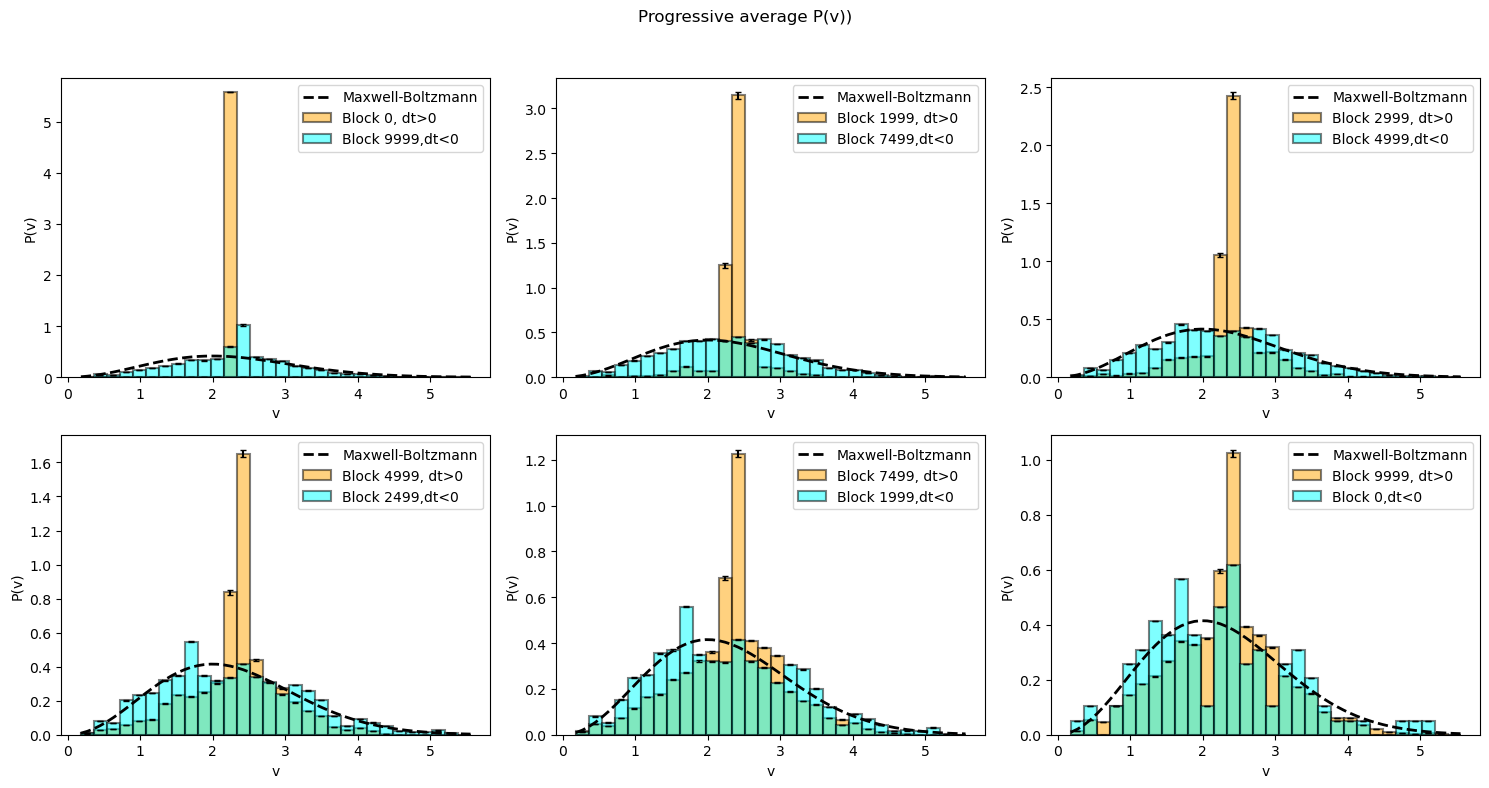

In [25]:
import numpy as np
import matplotlib.pyplot as plt
to_plot = [0,1999,2999,4999,7499,9999]
n_cols = len(to_plot)
fig, ax = plt.subplots(2, 3, figsize=(5 * 3, 8), sharex=False, sharey=False)
T=2.

h = fwd_histograms[0]
bin_centers = h['VMIN']+0.5*(h['VMAX']-h['VMIN'])
v_all = np.concatenate((h['VMIN'].values, bin_centers, h['VMAX'].values))
v_all = np.unique(v_all)  # Remove duplicates and sort

# Maxwell-Boltzmann distribution
mb_curve = Maxwell_Boltzmann(v_all, T)
vmax = v_all[np.argmax(mb_curve)]

area = bin_size*108.
bkw_idx=[9999,7499,4999,2499,1999,0]
for i,axes in enumerate(ax.flat):
    h_fwd = fwd_histograms[to_plot[i]]
    h_bkw = bkw_histograms[bkw_idx[i]]
    axes.plot(v_all, mb_curve, 'k--', linewidth=2, label='Maxwell-Boltzmann')
    axes.bar(bin_centers, h_fwd['PROG_AVE_POFV']/area, yerr= h_fwd['ERROR']/area,width=bin_size,color='orange',
            edgecolor='black', linewidth=1.5, alpha=0.5,label=f'Block {to_plot[i]}, dt>0', 
            error_kw=dict(ecolor='black', capsize=2)
            )
    axes.bar(bin_centers, h_bkw['PROG_AVE_POFV']/area, yerr= h_bkw['ERROR']/area,width=bin_size,color='cyan',
            edgecolor='black', linewidth=1.5,alpha=0.5, label=f'Block {bkw_idx[i]},dt<0', 
            error_kw=dict(ecolor='black', capsize=2)
            )
    axes.legend()
    axes.set_xlabel('v')
    axes.set_ylabel('P(v)')

fig.suptitle('Progressive average P(v))')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In these plots we can see the comparison between forwards (in orange) and backwards(in blue) evolution, at corresponding time indices(i.e. t=0 for the forwards simulation is block 0 and for backwards is the last block). Again, it is clear how the final state is not a dirac distribution.